In [1]:
import h5py as h5

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from skimage.feature import match_template
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.transform import rescale

In [2]:
#Read STEM data from h5file.
with h5.File('data/nanotube_rotational_STEM.h5','r') as h5file:
    data = (h5file['data'][:]).astype(np.float32)
    metadata = {}
    for key in h5file['data'].attrs:
        metadata[key] = h5file['data'].attrs.get(key)

In [3]:
#num_imgs, img_x, img_y
print(data.shape)

(18, 1024, 1024)


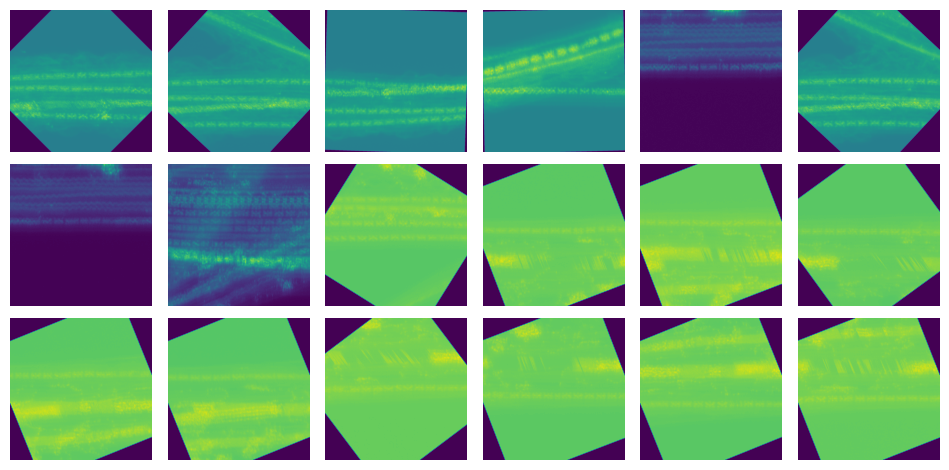

In [4]:
# quick display of data

# image data are pre-rotated manually. Ideally, the images would be aligned at time of acquisition
# by changing the rotation of the scan direction. 

scaling=0.6
fig,ax = plt.subplots(3,6,figsize=(16*scaling,8*scaling))
for (a,b) in zip(ax.ravel(),data):
    a.imshow(b)
    a.axis('off')
plt.tight_layout()
plt.show()

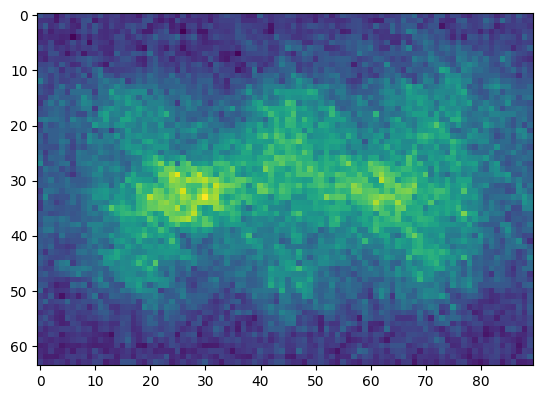

In [5]:
#Manually identifying a typical unit cell in an image and extracting to use for template matching

template_image_number = 5
template_coords = [478,542,423,513]
template = data[template_image_number][template_coords[0]:template_coords[1],template_coords[2]:template_coords[3]]

plt.imshow(template)
plt.show()

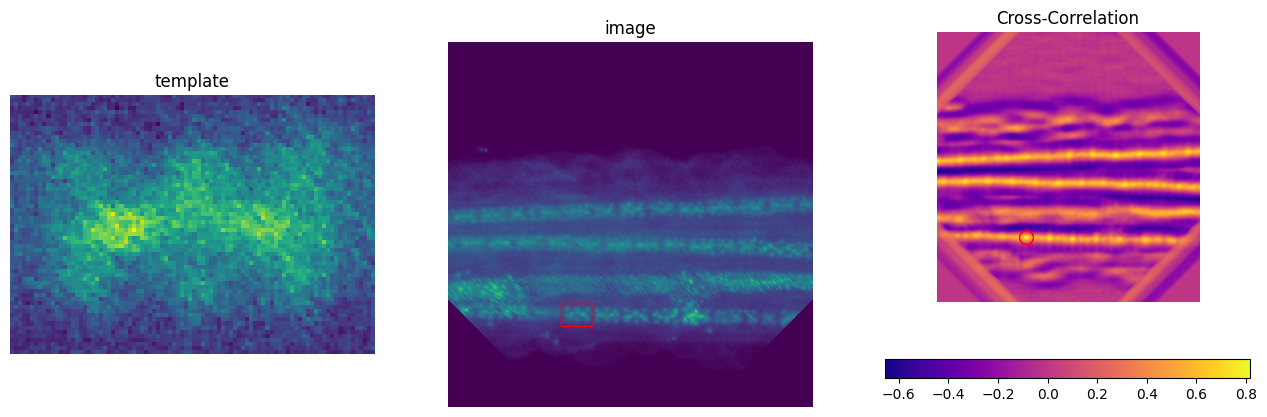

In [6]:
#Template matching for detection of similar unit cells using cross-correlation

image = data[0]

result = match_template(image, template) #Cross-correlation image
ij = np.unravel_index(np.argmax(result), result.shape) #find location of maximum CC
x, y = ij[::-1]

#plotting
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].imshow(template, cmap='viridis')
ax[0].set_axis_off()
ax[0].set_title('template')

ax[1].imshow(image, cmap='viridis',vmin=5000)
ax[1].set_axis_off()
ax[1].set_title('image')

# add bounding box to region that matches template
height_template, width_template = template.shape
rect = plt.Rectangle((x, y), width_template, height_template, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)


cc_im = ax[2].imshow(result,cmap='plasma')
ax[2].set_axis_off()
ax[2].set_title('Cross-Correlation')

# highlight maximum region
ax[2].autoscale(False)
ax[2].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.colorbar(cc_im,ax=ax[2],orientation='horizontal')

plt.show()

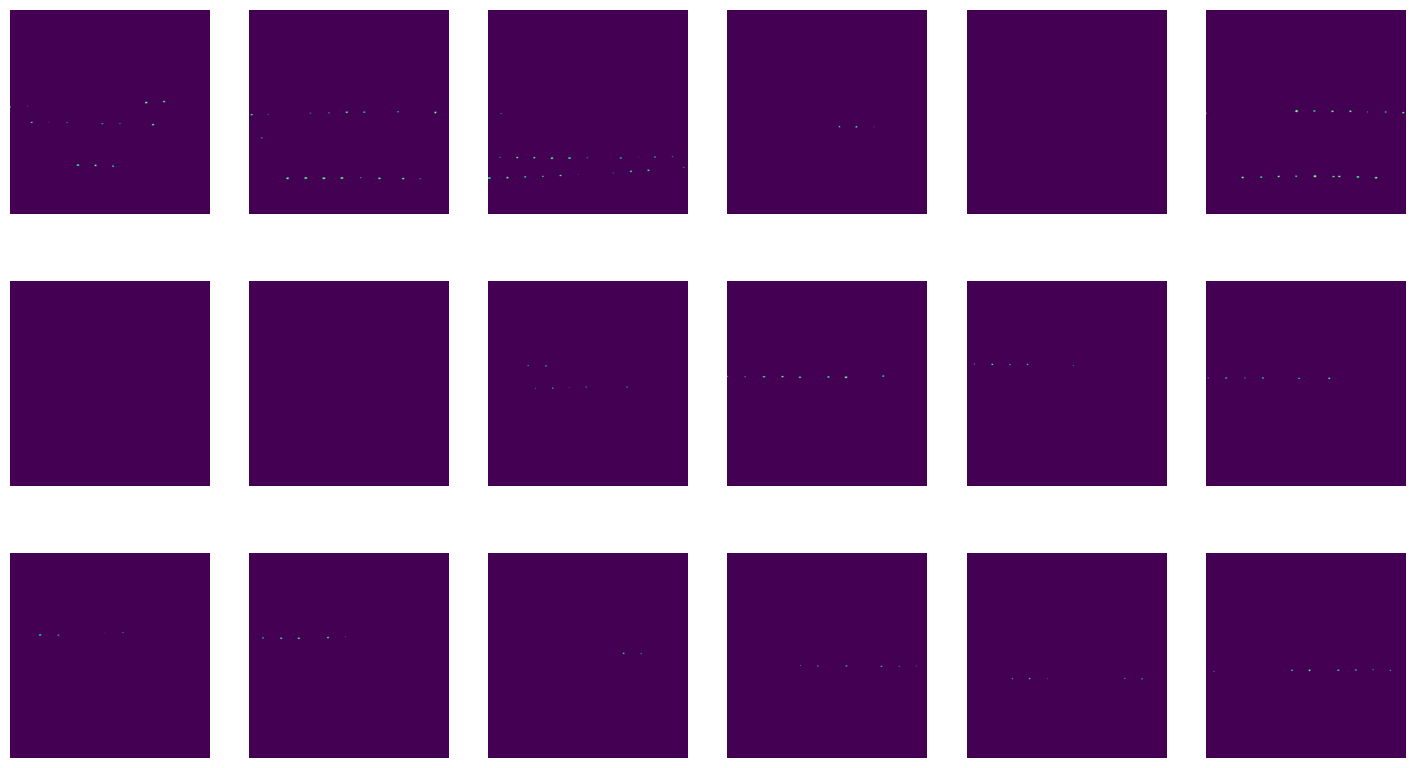

In [7]:
# finding all templates in all images

res_stack = [] 
THRESHOLD = 0.75 #manually setting global threshold for cc to find unit cells

for im in data:
    result = match_template(im, template)
    res_stack.append(result)

fig,ax = plt.subplots(3,6,figsize = (18,10))
for (a,b) in zip (ax.ravel(),res_stack):
    a.imshow(b>THRESHOLD)
    a.axis('off')
plt.show()

In [8]:
#finding all unit cells in all images and extracting
all_cell = [] #list for all extracted matches
height_template, width_template = template.shape

for (res,img) in zip(res_stack,data):
    label_img = label(res>THRESHOLD) # extracting binary regions
    regions = regionprops(label_img)
    for reg in regions:
        mask = label_img == reg.label
        dat = res*mask.astype(float)
        ij = np.unravel_index(np.argmax(dat), dat.shape) #finding peak in segmented region of cc image
        x, y = ij[::-1]
        
        cell = img[y:y+height_template,x:x+width_template] 
        all_cell.append(cell)
all_cell = np.array(all_cell)
all_cell.shape

(127, 64, 90)

In [ ]:
#background intensity subtraction using first and last scan line
bgs = np.array([0.5*(x[0,:].mean() + x[-1,:].mean()) for x in all_cell]) 
all_cell_bg = np.array([all_cell[x] - bgs[x] for x in np.arange(0,len(all_cell),1)])

#quick display of all matches
fig,ax = plt.subplots(10,12,figsize=(12,10))
for (a,b) in zip(ax.ravel(),all_cell_bg):
    a.imshow(b,cmap='viridis')
for a in ax.ravel():
    a.axis('off')
plt.show()

In [ ]:

rescale_stack = np.array([rescale(x,3) for x in all_cell_bg]) 
mean_rescale = rescale_stack.mean(0) # upsampling the stack to attempt better resolution

mean_cell = all_cell_bg.mean(0)

fig,ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(mean_cell)
ax[0].axis('off')
ax[0].set_title('Mean')
    
ax[1].imshow(mean_rescale)
ax[1].axis('off')
ax[1].set_title("Mean (Upsampled)")
    
plt.show()

In [ ]:
#making a composite image for figure
vlist = []
#manually choosing some unit cells
offset =101
for x in [0,4,12,16]:
    cells = all_cell_bg[offset+x:offset+x+4]
    cells2 = np.hstack(cells)
    vlist.append(cells2)
    
cell_grid = np.vstack(vlist)
plt.imshow(cell_grid)
plt.show()

In [ ]:
#Generate final figure

template_img = data[5][360:960,120:900]

fig,ax = plt.subplots(2,3,figsize=(24,10))
ax[0,0].imshow(template_img,vmin=5.5e3)

match = match_template(template_img,template)

ax[0,1].imshow(match,cmap='magma')
ax[1,0].imshow(match > 0.77,cmap = 'Reds')

rect = Rectangle((template_coords[2]-120,template_coords[0]-360),template_coords[3]-template_coords[2],
                 template_coords[1]-template_coords[0],facecolor='none',edgecolor='red')
ax[0,0].add_patch(rect)
#ax[0].set_xlim(120,900)
#ax[0].set_ylim(360,960)

ax[1,2].imshow(mean_rescale)
ax[0,2].imshow(template)

ax[1,1].imshow(cell_grid)

tsize=18

ax[0,0].axis('off')
ax[0,0].set_title('Original Image',fontsize=tsize)

ax[0,1].axis('off')
ax[0,1].set_title('Cross-Correlation',fontsize=tsize)

ax[1,0].axis('off')
ax[1,0].set_title('Threshold Image',fontsize=tsize)

ax[0,2].axis('off')
ax[0,2].set_title('Unit Cell Template',fontsize=tsize)

ax[1,2].axis('off')
ax[1,2].set_title('Average Unit Cell',fontsize=tsize)

ax[1,1].axis('off')
ax[1,1].set_title('Matches',fontsize=tsize)

sb1_len = 2/meta['pix_nm']
sb1 = Rectangle((10,len(template_img)-12-40),sb1_len,40,facecolor='white',edgecolor='k')
ax[0,0].add_patch(sb1)
ax[0,0].text(40,len(template_img)-20,'2 nm',color='k',fontsize = 18)

sb2_len = .2/meta['pix_nm']*3
sb2 = Rectangle((3,len(mean_rescale)-15-5),sb2_len,15,facecolor='white',edgecolor='k')
ax[1,2].add_patch(sb2)
ax[1,2].text(16,len(mean_rescale)-8,'2 $\AA$',color='k',fontsize = 18)

ax[0,0].text(4,38,'(a)',fontsize = 24, color='white')
ax[0,1].text(4,35,'(b)',fontsize = 24, color='white')
ax[1,0].text(4,38,'(c)',fontsize = 24, color='k')
ax[1,1].text(2,20,'(d)',fontsize = 24, color='w')
ax[0,2].text(0.2,4,'(e)',fontsize = 24, color='white')
ax[1,2].text(2,14,'(f)',fontsize = 24, color='white')

for x in range(0,5):
    ax[1,1].plot([x*template.shape[1],x*template.shape[1]],[0,template.shape[0]*4],'r')
    ax[1,1].plot([1,template.shape[1]*4],[x*template.shape[0],x*template.shape[0]],'r')
    
plt.tight_layout()
#plt.savefig('UnitCellAverage_TMTCNT.pdf',dpi=300)
plt.show()